In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import sys
from scipy.linalg import sqrtm
import scipy as sp 
import pandas as pd
import re
from collections import defaultdict
import analysis_tools_nonLin_June17 as temp_tools
import matplotlib as mpl
import pickle
from scipy.optimize import curve_fit
from analysis import fit_sine_square_decay
from fit_functions import sine_square_decay

In [2]:
# System parameters
gamma_e  = 0.91*1e6   # spontaneous decay rate of |e>, s^-1
gamma_f  = 0.057*1e6    # spontaneous decay rate of |f>
gamma_ge = 0#0.5117e6   # pure dephasing rate between |g> and |e>
gamma_ef = 0#0.16493413013193#0.2803e6   # pure dephasing rate between |e> and |f>

# Encircling loop parameters
T       = 6e-6       # total period, seconds
dt      = T / 1000    # time step
time = np.arange(0, T + dt, dt)
phase0  = 0
phase   = 2 * np.pi * time / T + phase0
J_EP = (gamma_e - gamma_f) / 4
print("J_EP = ", J_EP)

J_EP =  213250.0


In [3]:
def rabi_tomo(J_drive:float,
              omega:float,
              initial_state:str,):
# Drive detuning and amplitude arrays
    

    def lindblad_rhs(rho, delta, J, ge, gf, gde, gef):
        """Compute dρ/dt for a three-level dissipative system |g>, |e>, |f>."""
        # Collapse operators
        L_e  = np.zeros((3,3), complex)
        L_f  = np.zeros((3,3), complex)
        L_ge = np.zeros((3,3), complex)
        L_ef = np.zeros((3,3), complex)

        L_e[0,1]   = np.sqrt(ge)
        L_f[1,2]   = np.sqrt(gf)
        L_ge[1,1]  = np.sqrt(gde/2)
        L_ef[2,2]  = np.sqrt(gef/2)

        # Effective Hamiltonian in the |e>–|f> subspace
        H = np.array([
            [0,           0,      0     ],
            [0,    delta/2,      J     ],
            [0,  np.conj(J), -delta/2  ]
        ], dtype=complex)

        # Coherent part: -i[H, rho]
        comm = -1j * (H @ rho - rho @ H)

        # Dissipator sum_{k} (L_k ρ L_k† - ½{L_k†L_k, ρ})
        def collapse(L):
            return L @ rho @ L.conj().T - 0.5 * (L.conj().T @ L @ rho + rho @ (L.conj().T @ L))

        return comm + collapse(L_e) + collapse(L_f) + collapse(L_ge) + collapse(L_ef)

    # Initial state: prepare |e> in the {|g>,|e>,|f>} basis
    if initial_state == "e":# |e> in the subspace
        psi_ef = np.array([1, 0], complex)
    elif initial_state == "f":
        psi_ef = np.array([0, 1], complex)
    elif initial_state == "-x":#should be +y  this is the notation in exp
        psi_ef = np.array([1/np.sqrt(2), 1j*1/np.sqrt(2)], complex)
    elif initial_state == "+x":#-y
        psi_ef = np.array([1/np.sqrt(2), -1j*1/np.sqrt(2)], complex)
    elif initial_state == "-y":#+x
        psi_ef = np.array([1/np.sqrt(2), 1/np.sqrt(2)], complex)
    elif initial_state == "+y":#-x
        psi_ef = np.array([1/np.sqrt(2), -1/np.sqrt(2)], complex)
               
    psi0   = np.array([0, *psi_ef], complex)     # full-state vector
    rho    = np.zeros((3,3,len(time)), complex)
    rho[:,:,0] = np.outer(psi0, psi0.conj())

    # Time evolution via 4th-order Runge–Kutta
    rho_current = rho[:,:,0]
    for i in range(len(time)-1):
        k1 = lindblad_rhs(rho_current, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        k2 = lindblad_rhs(rho_current + 0.5*dt*k1, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        k3 = lindblad_rhs(rho_current + 0.5*dt*k2, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        k4 = lindblad_rhs(rho_current +     dt*k3, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        rho_current = rho_current + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        rho[:,:,i+1] = rho_current

    # Normalize to the |e>–|f> subspace (post-selection)
    # After your RK4 loop has filled `rho[:,:,i]` for each i...
    P_g_z = np.real(rho[0,0,:])  # ground state |g> population
    P_e_z = np.real(rho[1,1,:])  # excited state |e> population
    P_f_z = np.real(rho[2,2,:])  # second excited |f> population

    rho_ef = np.zeros((2,2,len(time)), complex)
    for i in range(len(time)):
        pop = rho[1,1,i] + rho[2,2,i]
        rho_ef[:,:,i] = rho[1:3,1:3,i] / pop

    # Pauli matrices in the EF subspace
    sigma_x = np.array([[0,1],[1,0]], complex)
    sigma_y = np.array([[0,-1j],[1j,0]], complex)
    sigma_z = np.array([[1,0],[0,-1]], complex)

    # Expectation values
    exp_x = np.real([np.trace(rho_ef[:,:,i] @ sigma_x) for i in range(len(time))])
    exp_y = np.real([np.trace(rho_ef[:,:,i] @ sigma_y) for i in range(len(time))])
    exp_z = np.real([np.trace(rho_ef[:,:,i] @ sigma_z) for i in range(len(time))])
    # sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    # sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    # sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    # I = np.eye(2, dtype=complex)
    # rho_construct =0.5 * (I + exp_x*sigma_x + exp_y*sigma_y + exp_z*sigma_z)
    P_e_y=(1-P_g_z) * (1 + exp_y) / 2
    P_f_y=(1-P_g_z) * (1 - exp_y) / 2
    P_e_x=(1-P_g_z) * (1 + exp_x) / 2
    P_f_x=(1-P_g_z) * (1 - exp_x) / 2
    return exp_x, exp_y, exp_z, rho_ef,rho,P_g_z,P_e_z,P_f_z,P_e_y,P_f_y,P_e_x,P_f_x


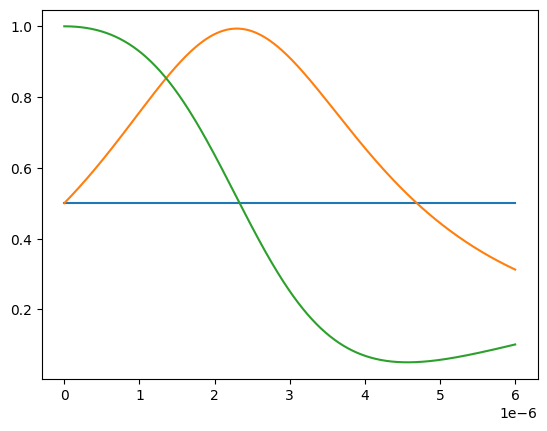

In [4]:
J_drive=1.02*J_EP
omega=0
exp_x, exp_y, exp_z, rho_ef_1,rho_1,P_g_z_1,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "e")
plt.plot(time,(1-exp_x)/2)
plt.plot(time,(1-exp_y)/2)
plt.plot(time,(1+exp_z)/2)

In [5]:

# Get the colormap
cmap = plt.get_cmap('viridis')
# First color (value 0.0)
first_color = cmap(0.1)

# Last color (value 1.0)
last_color = cmap(1.0/2)

mpl.rcParams.update({
    # Figure
    "figure.figsize": (3.5, 2.5),
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,

    # Font
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial"],

    # Axes
    "axes.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.right": False,

    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "ytick.minor.size": 1.5,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,

    # Lines
    "lines.linewidth": 1.0,
    "lines.markersize": 4.0,

    # Legend
    "legend.frameon": False,
    "legend.fontsize": 8,

    # Color cycle (custom PRL-style)
    'axes.prop_cycle': mpl.cycler(color=[
    "#377eb8",  # blue
    "#e41a1c",  # red
    "#4daf4a",  # green
    "#984ea3",  # purple
    "#ff7f00",  # orange
    "#a65628",  # brown
    "#f781bf",  # pink
    "#999999",  # gray
    "#66c2a5",  # cyan-teal
    "#fc8d62",  # coral
    "#8da0cb",  # indigo
])
})
def savefig_tight(name):
    plt.savefig(name, bbox_inches='tight', pad_inches=0.05)
data_folder = 'rabi_tomography_data_Jun272025/'
init_states, amplitudes, column_headers, data_dict = temp_tools.read_data_generate_dict(data_folder)

flattop_gauss_amp=0.1
a_to_J = ((2 * np.pi) / (2 * (2 * 46.8197 * 1e-3))) / (1*flattop_gauss_amp)
density_dict = {}

for state in init_states:
    density_dict[state] = {}
    for amp in amplitudes:
        df = data_dict[state][amp]['scaled']
        # time = df['time'].to_numpy()
        time, rho_2 = temp_tools.reconstruct_density_matrices_2_2_from_data_dict(df)

        # Get 3×3 GEF density matrices (EF coherence, G diagonal)
        _, rho_3 = temp_tools.get_rho_3_3_from_data_dict(df)

        # Store all in dictionary
        density_dict[state][amp] = {
            'time': time,
            'rho_2': rho_2,
            'rho_3': rho_3,
        }
    

Initial states: ['-x', '-y', 'e', 'f', 'x', 'y']
Amplitudes: ['0.0000703', '0.0001000', '0.0003000', '0.0005000', '0.0007193', '0.0010000', '0.0015000', '0.0050000', '0.0100000', '0.0300000']
Column Headers: {'P_e_z', 'P_f_y', 'time', 'P_f_z', 'P_g_z', 'P_f_x', 'P_e_x', 'P_e_y', 'P_g_x', 'P_g_y'}


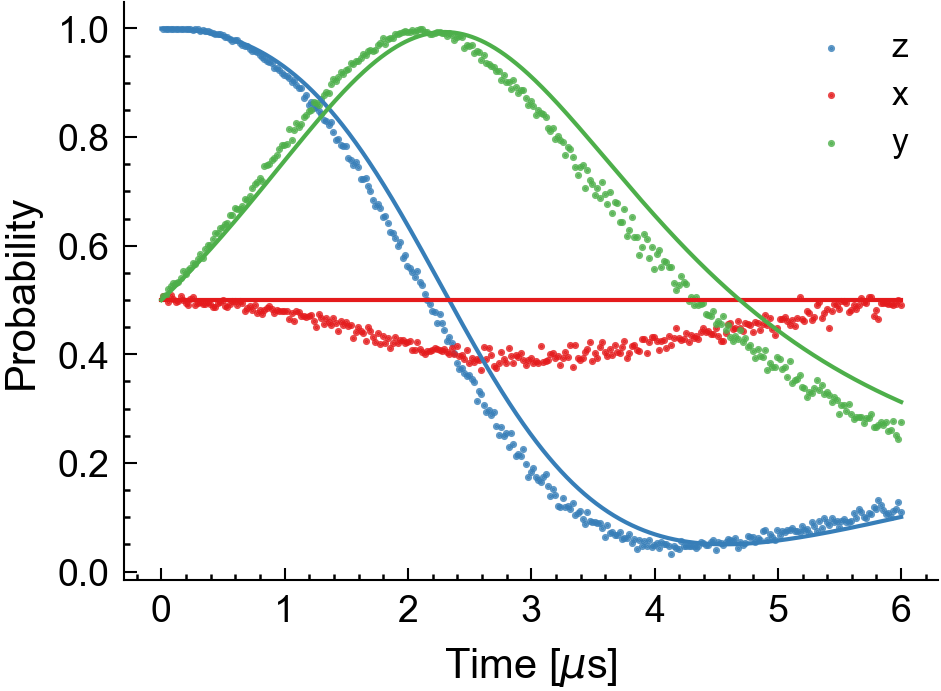

In [17]:
ep_tomo = data_dict['e']['0.0007193']['scaled']
# plt.plot(temp_tools.time*1e6, P_f_z/(P_f_z + P_e_z), 'C0'   , ls = 'dashdot')
# plt.plot(temp_tools.time*1e6, P_f_x/(P_f_x + P_e_x), 'C1'   , ls = 'dashdot')
# plt.plot(temp_tools.time*1e6,  P_f_y/(P_f_y + P_e_y), 'C2'  , ls = 'dashdot')
t = np.arange(0, T + dt, dt)*1e6
plt.scatter(ep_tomo['time']/1000,1- ep_tomo['P_f_z']/(ep_tomo['P_f_z'] + ep_tomo['P_e_z']), label = 'z', s = 0.5, alpha = 0.8)
plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_y']/(ep_tomo['P_f_y'] + ep_tomo['P_e_y']), label = 'x', s = 0.5, alpha = 0.8)
plt.scatter(ep_tomo['time']/1000, ep_tomo['P_f_x']/(ep_tomo['P_f_x'] + ep_tomo['P_e_x']), label = 'y', s= 0.5, alpha = 0.8)
plt.plot(t,(1+exp_z)/2)
plt.plot(t,(1-exp_x)/2)
plt.plot(t,(1-exp_y)/2)

plt.legend()
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Probability')
savefig_tight('Images/tomographyatEP(sim).pdf')

In [5]:
def reconstruct_density_matrix(expectation):
    """
    Reconstruct a 2×2 density matrix ρ from Bloch-vector expectations.
    
    ρ = ½ (I + ex·σx + ey·σy + ez·σz)
    
    Args:
      expectation: sequence or list [ex, ey, ez]
    Returns:
      2×2 complex ndarray ρ
    """
    ex, ey, ez = expectation
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    return 0.5 * (I + ex*sigma_x + ey*sigma_y + ez*sigma_z)

def nearest_pure_state(rho):
    """
    Find the pure state closest to ρ by taking the eigenvector 
    of ρ with the largest eigenvalue.
    
    Args:
      rho: 2×2 Hermitian density matrix
    Returns:
      lam_max:    largest eigenvalue (float)
      psi:        corresponding normalized eigenvector (length-2 complex array)
      rho_pure:   pure-state density matrix |ψ⟩⟨ψ|
    """
    eigvals, eigvecs = np.linalg.eigh(rho)
    idx = np.argmax(eigvals)
    lam_max = eigvals[idx]
    psi = eigvecs[:, idx]
    #(Optional) remove global phase so ψ[0] is real:
    # psi *= np.exp(-1j * np.angle(psi[0]))
    rho_pure = np.outer(psi, np.conj(psi))
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    exp_x_value = np.trace(rho_pure.dot(sigma_x)).real
    exp_y_value = np.trace(rho_pure.dot(sigma_y)).real
    exp_z_value = np.trace(rho_pure.dot(sigma_z)).real

    return lam_max, psi, rho_pure,exp_x_value, exp_y_value, exp_z_value

def time_series_reconstruction(xs, ys, zs):
    T = len(xs)
    rhos    = np.zeros((T,2,2), dtype=complex)
    eigvals = np.zeros(T)
    exp_x_pure   = np.zeros(T)
    exp_y_pure   = np.zeros(T)
    exp_z_pure   = np.zeros(T)
    psis    = np.zeros((T,2),   dtype=complex)
    rhos_p  = np.zeros((T,2,2), dtype=complex)

    for t, (ex, ey, ez) in enumerate(zip(xs, ys, zs)):
        # 1) reconstruct ρ and find raw eigenvector
        rho       = reconstruct_density_matrix([ex, ey, ez])
        lam, psi_raw, rho_p,exp_value_x,exp_value_y,exp_value_z = nearest_pure_state(rho)
        rhos[t]      = rho
        eigvals[t]   = lam
        psis[t]      = psi_raw
        rhos_p[t]    = rho_p
        exp_x_pure[t]     = exp_value_x
        exp_y_pure[t]     = exp_value_y
        exp_z_pure[t]     = exp_value_z

    return rhos, eigvals, psis, rhos_p, exp_x_pure, exp_y_pure, exp_z_pure

In [6]:
def build_phi_filtered_x(psi_e, psi_f, time,state: str,filter1,filter2):
    """
    1) Compute φ_t and F_t on the full dataset of length T.
    2) Drop all t with F_t < 0.94 → idx1
    3) Re-build φ / F on that reduced subset
    4) Drop all of those with F < 0.90 → idx2
    Returns:
      time2:   np.ndarray of surviving times
      phi2:    np.ndarray shape (N2,2) of surviving superpositions
      F2:      np.ndarray length N2 of surviving overlaps
      idx2:    tuple of original indices kept
    """
    psi_e = np.asarray(psi_e)
    psi_f = np.asarray(psi_f)

    T = psi_e.shape[0]

    # --- first pass on full data ---
    phi1 = np.zeros_like(psi_e, dtype=np.complex128)
    F1   = [1.0]

    # t=0
    raw0 = (psi_e[0] + (1j if state=="-x" else -1j)*psi_f[0]) / np.sqrt(2)
    phi1[0] = raw0  / np.linalg.norm(raw0)if np.linalg.norm(raw0) else raw0

    # t=1..T-1
    for t in range(1, T):
        prev = phi1[t-1]
        plus_raw  = (psi_e[t] + 1j*psi_f[t]) / np.sqrt(2)
        minus_raw = (psi_e[t] - 1j*psi_f[t]) / np.sqrt(2)

        # normalized candidates
        phi_p = plus_raw    / np.linalg.norm(plus_raw)if np.linalg.norm(plus_raw)  else plus_raw
        phi_m = minus_raw / np.linalg.norm(minus_raw)if np.linalg.norm(minus_raw) else minus_raw

        # overlaps
        F_p = abs(np.vdot(prev, phi_p))
        F_m = abs(np.vdot(prev, phi_m))

        if F_p >= F_m:
            phi1[t], F1_t = phi_p, F_p
        else:
            phi1[t], F1_t = phi_m, F_m

        F1.append(F1_t)

    F1 = np.array(F1)

    # first filter: keep F ≥ 0.94
    idx1 = np.where(F1 >= filter1)[0]
    psi_e1, psi_f1, time1 = psi_e[idx1], psi_f[idx1], time[idx1]

    # --- second pass on reduced data ---
    N1 = len(idx1)
    phi2 = np.zeros((N1, psi_e.shape[1]), dtype=np.complex128)
    F2   = [1.0]

    # re-init φ at the first reduced point
    raw0 = (psi_e1[0] + (1j if state=="-x" else -1j)*psi_f1[0]) / np.sqrt(2)
    phi2[0] = raw0 / np.linalg.norm(raw0) if np.linalg.norm(raw0) else raw0

    for k in range(1, N1):
        prev = phi2[k-1]
        plus_raw  = (psi_e1[k] + 1j*psi_f1[k]) / np.sqrt(2)
        minus_raw = (psi_e1[k] - 1j*psi_f1[k]) / np.sqrt(2)

        phi_p = plus_raw  / np.linalg.norm(plus_raw)  if np.linalg.norm(plus_raw)  else plus_raw
        phi_m = minus_raw / np.linalg.norm(minus_raw) if np.linalg.norm(minus_raw) else minus_raw

        F_p = abs(np.vdot(prev, phi_p))
        F_m = abs(np.vdot(prev, phi_m))

        if F_p >= F_m:
            phi2[k], F2_t = phi_p, F_p
        else:
            phi2[k], F2_t = phi_m, F_m

        F2.append(F2_t)

    F2 = np.array(F2)

    # second filter: keep F ≥ 0.90
    idx2_rel = np.where(F2 >= filter2)[0]
    idx2     = idx1[idx2_rel]                   # map back to original indices
    phi2_f   = phi2[idx2_rel]
    F2_f     = F2[idx2_rel]


    
    # print(F2_f )
    return phi2_f, F2_f, idx2

    
def build_phi_filtered_y(psi_e, psi_f, time,state: str,filter1,filter2):
    """
    1) Compute φ_t and F_t on the full dataset of length T.
    2) Drop all t with F_t < 0.94 → idx1
    3) Re-build φ / F on that reduced subset
    4) Drop all of those with F < 0.90 → idx2
    Returns:
      time2:   np.ndarray of surviving times
      phi2:    np.ndarray shape (N2,2) of surviving superpositions
      F2:      np.ndarray length N2 of surviving overlaps
      idx2:    tuple of original indices kept
    """
    psi_e = np.asarray(psi_e)
    psi_f = np.asarray(psi_f)

    T = psi_e.shape[0]

    # --- first pass on full data ---
    phi1 = np.zeros_like(psi_e, dtype=np.complex128)
    F1   = [1.0]

    # t=0
    raw0 = (psi_e[0] + (1 if state=="-y" else -1)*psi_f[0]) / np.sqrt(2)
    phi1[0] = raw0 / np.linalg.norm(raw0) if np.linalg.norm(raw0) else raw0

    # t=1..T-1
    for t in range(1, T):
        prev = phi1[t-1]
        plus_raw  = (psi_e[t] + 1*psi_f[t]) / np.sqrt(2)
        minus_raw = (psi_e[t] - 1*psi_f[t]) / np.sqrt(2)

        # normalized candidates
        phi_p = plus_raw  / np.linalg.norm(plus_raw)  if np.linalg.norm(plus_raw)  else plus_raw
        phi_m = minus_raw / np.linalg.norm(minus_raw) if np.linalg.norm(minus_raw) else minus_raw

        # overlaps
        F_p = abs(np.vdot(prev, phi_p))
        F_m = abs(np.vdot(prev, phi_m))

        if F_p >= F_m:
            phi1[t], F1_t = phi_p, F_p
        else:
            phi1[t], F1_t = phi_m, F_m

        F1.append(F1_t)

    F1 = np.array(F1)

    # first filter: keep F ≥ 0.94
    idx1 = np.where(F1 >= filter1)[0]
    psi_e1, psi_f1, time1 = psi_e[idx1], psi_f[idx1], time[idx1]

    # --- second pass on reduced data ---
    N1 = len(idx1)
    phi2 = np.zeros((N1, psi_e.shape[1]), dtype=np.complex128)
    F2   = [1.0]

    # re-init φ at the first reduced point
    raw0 = (psi_e1[0] + (1 if state=="-y" else -1)*psi_f1[0]) / np.sqrt(2)
    phi2[0] = raw0 / np.linalg.norm(raw0) if np.linalg.norm(raw0) else raw0

    for k in range(1, N1):
        prev = phi2[k-1]
        plus_raw  = (psi_e1[k] + 1*psi_f1[k]) / np.sqrt(2)
        minus_raw = (psi_e1[k] - 1*psi_f1[k]) / np.sqrt(2)

        phi_p = plus_raw  / np.linalg.norm(plus_raw)  if np.linalg.norm(plus_raw)  else plus_raw
        phi_m = minus_raw / np.linalg.norm(minus_raw) if np.linalg.norm(minus_raw) else minus_raw

        F_p = abs(np.vdot(prev, phi_p))
        F_m = abs(np.vdot(prev, phi_m))

        if F_p >= F_m:
            phi2[k], F2_t = phi_p, F_p
        else:
            phi2[k], F2_t = phi_m, F_m

        F2.append(F2_t)

    F2 = np.array(F2)

    # second filter: keep F ≥ 0.90
    idx2_rel = np.where(F2 >= filter2)[0]
    idx2     = idx1[idx2_rel]                   # map back to original indices
    phi2_f   = phi2[idx2_rel]
    F2_f     = F2[idx2_rel]


    
    # print(F2_f )
    return phi2_f, F2_f, idx2
def compute_ofs(phi_ts, psi_x):
    """
    Args:
      phi_ts: array shape (T,2), as returned by build_phi()
      psi_x:  array shape (T,2), pure‐state vectors for initial |x>
    Returns:
      ofs: complex array shape (T,), the overlap at each t
    """

    
    
    # ⟨Φ|ψ⟩ = sum conj(phi) * psi along the second axis
    numer = np.einsum('ij,ij->i', np.conjugate(psi_x),phi_ts )
    # norm = √⟨ψ|ψ⟩  (should be 1 if psi_x was normalized)
    # norms = np.linalg.norm(psi_x, axis=1)
    return numer**2

def enforce_continuous_phase(psi_array: np.ndarray, comp: int = 1) -> np.ndarray:
    """
    Given psi_array of shape (T, 2), returns a new array psi_fixed
    where for each t:
      1) the comp-th component is made real and positive,
      2) the sign is chosen (±) to minimize the jump from psi_fixed[t-1].
    
    Args:
      psi_array: raw eigenvector series, shape (T,2), complex dtype
      comp:      which component to force real (0 or 1)
    
    Returns:
      psi_fixed: shape (T,2), smoothly phased
    """
    T, N = psi_array.shape
    psi_fixed = np.zeros_like(psi_array, dtype=complex)

    # t = 0: cancel phase of component `comp` and force it positive
    phi0 = np.angle(psi_array[0, comp])
    psi0 = psi_array[0] * np.exp(-1j * phi0)
    if np.real(psi0[comp]) < 0:
        psi0 = -psi0
    
    psi_fixed[0] = psi0

    # t = 1…T-1: cancel comp-phase, then pick sign minimizing jump
    for t in range(1, T):
        raw = psi_array[t]
        phi = np.angle(raw[comp])
        cand = raw * np.exp(-1j * phi)    # make comp real
        cand_neg = -cand                  # alternative sign

        prev = psi_fixed[t-1]
        d1 = np.linalg.norm(cand     - prev,ord=np.inf)
        d2 = np.linalg.norm(cand_neg - prev,ord=np.inf)

        psi_fixed[t] = cand if d1 < d2 else cand_neg

    return psi_fixed

In [7]:
def get_intergral(r:float):
    J_drive=r*J_EP
    omega=0.0*1e6*2*np.pi 
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,P_g_z_1,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "e")
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,P_g_z_2,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "f")
    P_s=(1-P_g_z_1)/(1-P_g_z_2)
    T_max = 6e-6
    mask = time <= T_max   # only take points within [0, 6 µs]
    
    time_window = time[mask]
    P_s_window = P_s[mask]
    
    # Do numerical integration (trapezoidal rule)
    integral = np.trapz(abs(P_s_window-1), time_window)
    
    # Normalize by total window length
    avg_success = integral / (time_window[-1] - time_window[0])
    return avg_success
    

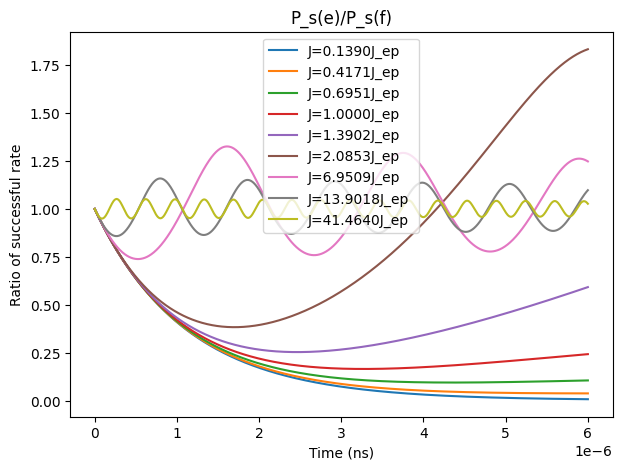

In [8]:
r_list=[0.1390182006138945,
0.41705460184168347,
0.6950910030694725,
0.9999579170157431,
1.390182006138945,
2.085273009208418,
6.9509100306947245,
13.901820061389449,
41.46397049683007]#
all_results = {}
plt.figure(figsize=(7, 5))
for r in r_list:
    J_drive=r*J_EP
    omega=0.0*1e6*2*np.pi 
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,P_g_z_1,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "e")
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,P_g_z_2,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "f")
    P_s=(1-P_g_z_1)/(1-P_g_z_2)
    plt.plot(time,P_s,label=f'J={float(r):.4f}J_ep ')
plt.xlabel('Time (ns)')
plt.ylabel('Ratio of successful rate')  
plt.legend()
plt.title(f'P_s(e)/P_s(f)')
plt.show()

In [9]:
r_list = np.arange(0,45,.1)
success_list = np.zeros(len(r_list))
for i,r in enumerate(r_list):
    success_list[i]=get_intergral(r)
plt.plot(r_list,success_list)

    


KeyboardInterrupt: 

In [ ]:
plt.plot(r_list,success_list)
plt.xlabel("J/J_ep")
plt.show()

In [ ]:
F1=0.99
F2=0.99

state="+x"
r_list=[0.1390182006138945,
0.41705460184168347,
0.6950910030694725,
0.9999579170157431,
1.390182006138945,
2.085273009208418,
6.9509100306947245,
13.901820061389449,
41.46397049683007]#

all_results = {}
plt.figure(figsize=(7, 5))
for r in r_list:
    J_drive=r*J_EP
    omega=0.0*1e6*2*np.pi 
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "e")
    exp_x2, exp_y2, exp_z2, rho_ef_2,rho_2,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "f")
    exp_x3, exp_y3, exp_z3, rho_ef_3,rho_3,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, state)
    _, _, psis_e, _,_,_,_ = time_series_reconstruction(exp_x1,exp_y1,exp_z1)
    _, _, psis_f, _,_,_,_ = time_series_reconstruction(exp_x2,exp_y2,exp_z2)
    _, _, psi, _,_,_,_ = time_series_reconstruction(exp_x3,exp_y3,exp_z3)
    psi_e= enforce_continuous_phase(psis_e,0)
    psi_f= enforce_continuous_phase(psis_f,1)
    if state == '-x' or state == '+x':
        phi_ts,F_plus,idx= build_phi_filtered_x(psi_e, psi_f,time,state,F1,F2)
    elif state == '-y' or state == '+y':
        phi_ts,F_plus,idx= build_phi_filtered_y(psi_e, psi_f,time,state,F1,F2)
    psi=psi[idx]
    time=time[idx]
    ofs = compute_ofs(psi, phi_ts)
    plt.plot(time,abs(ofs),label=f'J={float(r):.4f}J_ep ')
plt.xlabel('Time (ns)')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Time ({state} state)')

# plt.xlim(0,4000)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout()    
plt.show()

   




In [ ]:
F1=0.99
F2=0.99

state="-x"
r_list=[0.1390182006138945,
0.41705460184168347,
0.6950910030694725,
0.9999579170157431,
1.390182006138945,
2.085273009208418,
6.9509100306947245,
13.901820061389449,
41.46397049683007]#

all_results = {}
plt.figure(figsize=(7, 5))
for r in r_list:
    J_drive=r*J_EP
    omega=0.0*1e6*2*np.pi 
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "e")
    exp_x2, exp_y2, exp_z2, rho_ef_2,rho_2,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "f")
    exp_x3, exp_y3, exp_z3, rho_ef_3,rho_3,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, state)
    _, _, psis_e, _,_,_,_ = time_series_reconstruction(exp_x1,exp_y1,exp_z1)
    _, _, psis_f, _,_,_,_ = time_series_reconstruction(exp_x2,exp_y2,exp_z2)
    _, _, psi, _,_,_,_ = time_series_reconstruction(exp_x3,exp_y3,exp_z3)
    psi_e= enforce_continuous_phase(psis_e,0)
    psi_f= enforce_continuous_phase(psis_f,1)
    if state == '-x' or state == '+x':
        phi_ts,F_plus,idx= build_phi_filtered_x(psi_e, psi_f,time,state,F1,F2)
    elif state == '-y' or state == '+y':
        phi_ts,F_plus,idx= build_phi_filtered_y(psi_e, psi_f,time,state,F1,F2)
    psi=psi[idx]
    time=time[idx]
    ofs = compute_ofs(psi, phi_ts)
    plt.plot(time,abs(ofs),label=f'J={float(r):.4f}J_ep ')
plt.xlabel('Time (ns)')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Time ({state} state)')

# plt.xlim(0,4000)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout()    
plt.show()

In [ ]:
F1=0.99
F2=0.99

state="+y"
r_list=[0.1390182006138945,
0.41705460184168347,
0.6950910030694725,
0.9999579170157431,
1.390182006138945,
2.085273009208418,
6.9509100306947245,
13.901820061389449,
41.46397049683007]#

all_results = {}
plt.figure(figsize=(7, 5))
for r in r_list:
    J_drive=r*J_EP
    omega=0.0*1e6*2*np.pi 
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "e")
    exp_x2, exp_y2, exp_z2, rho_ef_2,rho_2,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "f")
    exp_x3, exp_y3, exp_z3, rho_ef_3,rho_3,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, state)
    _, _, psis_e, _,_,_,_ = time_series_reconstruction(exp_x1,exp_y1,exp_z1)
    _, _, psis_f, _,_,_,_ = time_series_reconstruction(exp_x2,exp_y2,exp_z2)
    _, _, psi, _,_,_,_ = time_series_reconstruction(exp_x3,exp_y3,exp_z3)
    psi_e= enforce_continuous_phase(psis_e,0)
    psi_f= enforce_continuous_phase(psis_f,1)
    if state == '-x' or state == '+x':
        phi_ts,F_plus,idx= build_phi_filtered_x(psi_e, psi_f,time,state,F1,F2)
    elif state == '-y' or state == '+y':
        phi_ts,F_plus,idx= build_phi_filtered_y(psi_e, psi_f,time,state,F1,F2)
    psi=psi[idx]
    time=time[idx]
    ofs = compute_ofs(psi, phi_ts)
    plt.plot(time,abs(ofs),label=f'J={float(r):.4f}J_ep ')
plt.xlabel('Time (ns)')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Time ({state} state)')

# plt.xlim(0,4000)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout()    
plt.show()

In [ ]:
F1=0.99
F2=0.99

state="-y"
r_list=[0.1390182006138945,
0.41705460184168347,
0.6950910030694725,
0.9999579170157431,
1.390182006138945,
2.085273009208418,
6.9509100306947245,
13.901820061389449,
41.46397049683007]#

all_results = {}
plt.figure(figsize=(7, 5))
for r in r_list:
    J_drive=r*J_EP
    omega=0.0*1e6*2*np.pi 
    exp_x1, exp_y1, exp_z1, rho_ef_1,rho_1,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "e")
    exp_x2, exp_y2, exp_z2, rho_ef_2,rho_2,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, "f")
    exp_x3, exp_y3, exp_z3, rho_ef_3,rho_3,_,_,_,_,_,_,_=rabi_tomo(J_drive, omega, state)
    _, _, psis_e, _,_,_,_ = time_series_reconstruction(exp_x1,exp_y1,exp_z1)
    _, _, psis_f, _,_,_,_ = time_series_reconstruction(exp_x2,exp_y2,exp_z2)
    _, _, psi, _,_,_,_ = time_series_reconstruction(exp_x3,exp_y3,exp_z3)
    psi_e= enforce_continuous_phase(psis_e,0)
    psi_f= enforce_continuous_phase(psis_f,1)
    if state == '-x' or state == '+x':
        phi_ts,F_plus,idx= build_phi_filtered_x(psi_e, psi_f,time,state,F1,F2)
    elif state == '-y' or state == '+y':
        phi_ts,F_plus,idx= build_phi_filtered_y(psi_e, psi_f,time,state,F1,F2)
    psi=psi[idx]
    time=time[idx]
    ofs = compute_ofs(psi, phi_ts)
    plt.plot(time,abs(ofs),label=f'J={float(r):.4f}J_ep ')
plt.xlabel('Time (ns)')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Time ({state} state)')

# plt.xlim(0,4000)
plt.ylim(0,1.1)
plt.legend()
plt.tight_layout()    
plt.show()